<h1 align="center">
<img src="https://drive.google.com/uc?export=view&id=1_ZkE3dnYg9KykzdZE6lIK2s_q_nbiKk_" width="160" height="160">
</h1>
<h1 align="center"> Reinforcement Learning - 40957</h1>
<h3 align="center">Dr. Rohban, Mr. Hasani</h3>
<h5 align="center">Sharif University of Technology<br/>Computer Engineering Department<br/>  Spring 2023</h5>

---

# Homework 03
<h3 align="center"><b>Vahid Pourakbar 400205511</b></h3>

# Question 5 - Multi-Armed Bandit
---

In [10]:
import numpy as np

In [1]:
from scipy.stats import norm
import matplotlib.pyplot as plt

In [2]:
def plot_distribution(ax, pdfs, title=''): 
    x = np.linspace(0., 10., 200)
    ymax = 0    
    for index, pdf in enumerate(pdfs):
        y = norm.pdf(x, pdf.mean, np.sqrt(pdf.var))

        p = ax.plot(x, y, lw = 2)
        c = p[0].get_markeredgecolor()    
        ax.fill_between(x, y, 0, color=c, alpha=0.2 )    
        ax.autoscale(tight=True)
        ax.vlines(pdf.mean, 0, y.max(), colors = c, linestyles = "--", lw = 2)    

        ymax = max( ymax, y[1:].max()*1.05 )
    ax.set_ylim([0,ymax])

def plot_regret(ax, regret, title=''): 
    ax.plot(regret)

def plot(regret, mab):
    fig, axs = plt.subplots(1, 2, figsize=(6, 3))
    plot_regret(axs[0], regret)
    plot_distribution(axs[1], mab)

In [3]:
class Arm:
    def __init__(self, mean, var):
        self.mean = mean
        self.var = var

    def sample(self):
        return np.random.normal(self.mean, np.sqrt(self.var))

    def name(self):
        return 'N(' + str(self.mean) + ',' + str(self.var) + ')'

# Thompson Sampling

In this exercise we will run thompson sampling for 2-armed bandit with gaussian distribution.
For simplicity assume we know variance of distribution of arms and only mean is unknown
for prior assume gaussian distribution.

## 1.
if variance was unknown what prior distribtion would be suitable?

If the variance of the arms' distributions is unknown in a Thompson Sampling algorithm, a suitable prior distribution for the variance could be the Inverse Gamma distribution. The Inverse Gamma distribution is commonly used as a conjugate prior for the variance parameter of a Gaussian distribution.

The Inverse Gamma distribution is defined by two parameters: shape (alpha) and scale (beta). The shape parameter controls the shape of the distribution, and the scale parameter controls the spread. By choosing appropriate values for alpha and beta, you can express different prior beliefs about the variance.

Using the Inverse Gamma distribution as the prior for the variance allows the algorithm to update the posterior distribution based on observed data, which leads to an improved estimate of the variance over time. This enables the algorithm to adapt and make more informed decisions in a dynamic environment.

It's worth noting that incorporating unknown variances in Thompson Sampling can be more challenging than when only the means are unknown. It requires more complex updates to the posterior distributions and potentially additional sampling techniques. However, the Inverse Gamma distribution provides a suitable prior distribution for this scenario.

## 2.
Implement Thompson Sampling algorithm. For comparison also implement ϵ-Greedy and UCB algorithms

In [4]:
class ThompsonSampling:
    def __init__(self, var_list, **kwargs):
        """
        variance of arms are known to policy
        """
        self.n_arms = len(var_list)
        self.var_list = var_list
        self.prior_means = np.zeros((self.n_arms, ))
        self.prior_vars = np.ones((self.n_arms, )) * 1000
        self.num_selects = np.zeros((self.n_arms, ))

    def select_arm(self, *args):
        # ==================================== Your Code (Begin) ==================================
        # select arm based on estimate of prior distribution
        # return index of selected arm
        sampled_means = [
            np.random.normal(*x) for x in zip(self.prior_means, self.prior_vars)
        ]
        return np.argmax(sampled_means)
        # ==================================== Your Code (End) ====================================

    def update(self, idx, reward):
        # ==================================== Your Code (Begin) ==================================
        # update prior based on reward
        self.num_selects[idx] += 1
        self.prior_means[idx] = (self.prior_vars[idx] / (self.prior_vars[idx] + self.var_list[idx])) * reward \
        + (self.var_list[idx] / (self.prior_vars[idx] + self.var_list[idx])) * self.prior_means[idx]
        self.prior_vars[idx] = 1 / (1 / self.prior_vars[idx] + 1 / self.var_list[idx])
        # ==================================== Your Code (End) ====================================

In [5]:
class UCB:    
    def __init__(self, n_bandits, c_level):
        """
        c_level: coefficient of uncertainty
        """
        self.n_bandits = n_bandits
        self.c_level = c_level
        self.num_selects = np.zeros((n_bandits, ))
        self.sum_rewards = np.zeros((n_bandits, ))
    
    def select_arm(self, t):
        """
        t: step time
        """
        # ==================================== Your Code (Begin) ==================================
        # select arm based on UCB
        # return index of selected arm
        ucb_values = self.sum_rewards / self.num_selects + np.sqrt(self.c_level * np.log(t) / (self.num_selects + 1e-8))
        return np.argmax(ucb_values)
        # ==================================== Your Code (End) ====================================

    def update(self, idx, reward):
        # ==================================== Your Code (Begin) ==================================
        # update based on reward
        self.num_selects[idx] += 1
        self.sum_rewards[idx] += reward
        # ==================================== Your Code (End) ====================================

In [6]:
class eGreedy:    
    def __init__(self, n_bandits, epsilon):
        """
        epsilon must be given
        """
        self.n_bandits = n_bandits
        self.epsilon = epsilon
        self.num_selects = np.zeros((n_bandits, ))
        self.sum_rewards = np.zeros((n_bandits, ))
    
    def select_arm(self, *args):
        # ==================================== Your Code (Begin) ==================================
        # select arm based on e-Greedy
        # return index of selected arm
        if np.random.random() < self.epsilon:
            return np.random.randint(self.n_bandits)
        else:
            return np.argmax(self.sum_rewards / (self.num_selects + 1e-8))
        # ==================================== Your Code (End) ====================================

    def update(self, idx, reward):
        # ==================================== Your Code (Begin) ==================================
        # update based on reward
        self.num_selects[idx] += 1
        self.sum_rewards[idx] += reward
        # ==================================== Your Code (End) ====================================

## 3
run simulation for arms described as cells below and describe the differences of regret with different variance in arms distributions

rum_sim1 must return cumulitive regret formulated as 
$$
R(T)=\sum_{i=1}^2 N_i(T) \Delta_i
$$

where $N_i(T)$ is number of times arm $i$ was selected until step $T$, $\Delta_i=\mu^*-\mu_i$, $\mu^*$ is largest mean in arms distribtions and $\mu_i$ is mean of distribution of arm $i$

to get average regret we rum simulation 50 times.

In [48]:
def run_sim1(policy, mab, step_num=100):
    """
    run simulation of multi-armed bandit
    mab: list of arms
    """
    best_mean = np.max([b.mean for b in mab])
    # cumulative_regret = 0
    regret = []
    for k in range(step_num):          
        # ==================================== Your Code (Begin) ==================================
        # run policy algorithm and return cumulative regret
        arm_idx = policy.select_arm(k+1)
        reward = mab[arm_idx].sample()
        policy.update(arm_idx, reward)
        regret.append(policy.num_selects[arm_idx] * (best_mean - mab[arm_idx].mean))
        # ==================================== Your Code (End) ====================================
    return regret

### 3.1
Assume Multi-Armed Bandit variables are as follows.

In [46]:
mab = [Arm(6, 0.5), Arm(4, 0.5)] 

#### Thompson Sampling
run and describe the result.

By executing this code, we will obtain a plot showing the cumulative regret over time and the estimated distributions of the arms based on the Thompson Sampling algorithm.

The result of the Thompson Sampling algorithm will indicate how well it explores and exploits the two arms to maximize the cumulative reward. The algorithm dynamically adapts its arm selection based on the observed rewards and the estimated means and variances of the arms' distributions.

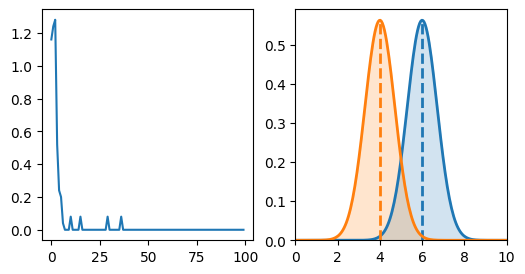

In [50]:
regret = [run_sim1(ThompsonSampling([b.var for b in mab]), mab) for _ in range(50)]
plot(np.mean(regret, axis=0), mab)

#### ϵ-Greedy
run for different values of ϵ and compare results.

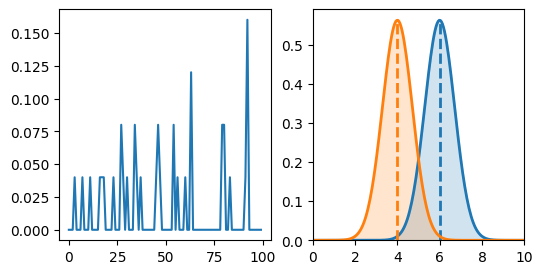

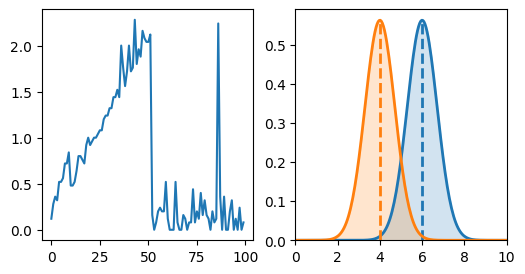

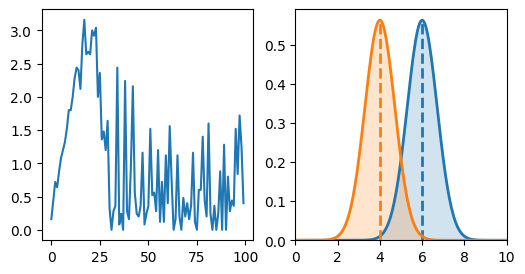

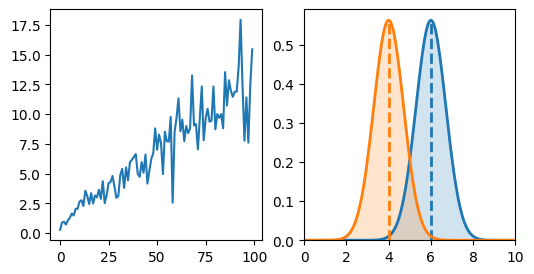

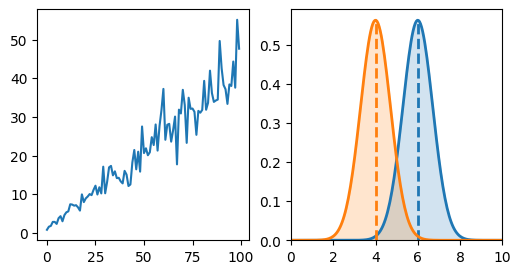

In [56]:
for epsilon in [0.01, 0.05, 0.1, 0.5, 0.9]:
  regret = [run_sim1(eGreedy(2, epsilon=epsilon), mab) for _ in range(50)]
  plot(np.mean(regret, axis=0), mab)

#### UCB
run for different values of confidence level and compare results.


<ipython-input-5-24d477be6eea>:18: RuntimeWarning: invalid value encountered in true_divide
  ucb_values = self.sum_rewards / self.num_selects + np.sqrt(self.c_level * np.log(t) / (self.num_selects + 1e-8))


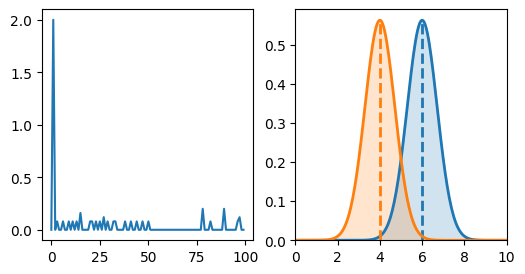

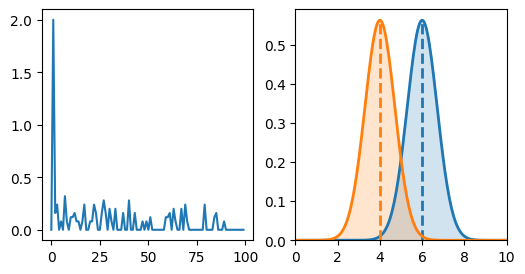

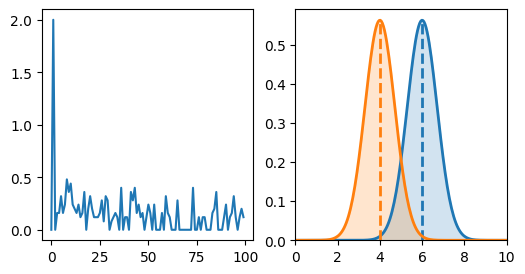

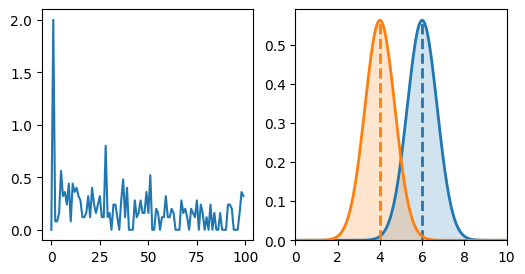

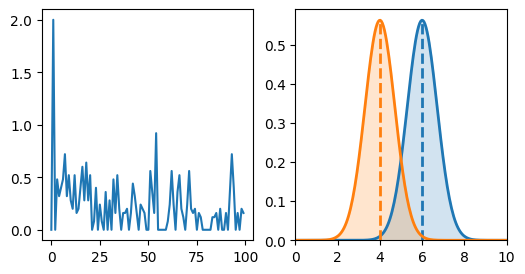

In [57]:
for c_level in [1, 2, 3, 4, 5]:
  regret = [run_sim1(UCB(2, c_level=c_level), mab) for _ in range(50)]
  plot(np.mean(regret, axis=0), mab)

### 3.2
Assume Multi-Armed Bandit variables are as follows.

In [67]:
mab = [Arm(6, 10), Arm(4, 10)]

#### Thompson Sampling
run and compare results.

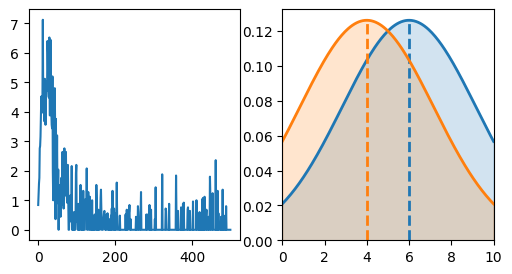

In [59]:
regret = [run_sim1(ThompsonSampling([b.var for b in mab]), mab, step_num=500) for _ in range(50)]
plot(np.mean(regret, axis=0), mab)

#### ϵ-Greedy
run for different values of ϵ and compare results.

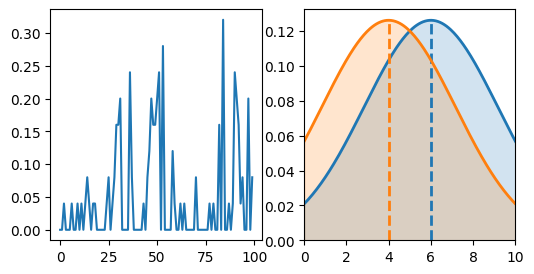

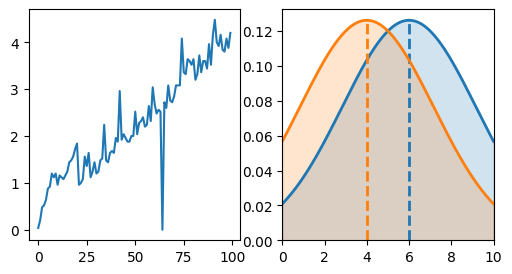

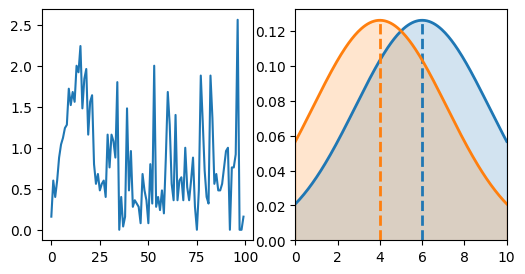

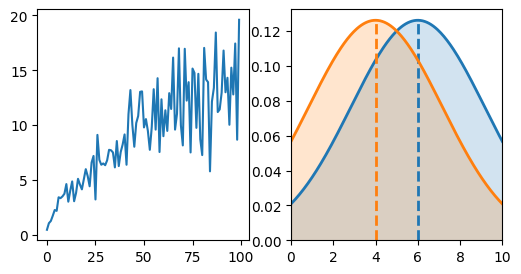

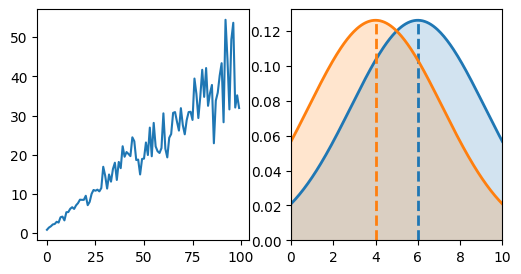

In [60]:
for epsilon in [0.01, 0.05, 0.1, 0.5, 0.9]:
  regret = [run_sim1(eGreedy(2, epsilon=epsilon), mab) for _ in range(50)]
  plot(np.mean(regret, axis=0), mab)

#### UCB
run for different values of confidence level and compare results.

<ipython-input-5-24d477be6eea>:18: RuntimeWarning: invalid value encountered in true_divide
  ucb_values = self.sum_rewards / self.num_selects + np.sqrt(self.c_level * np.log(t) / (self.num_selects + 1e-8))


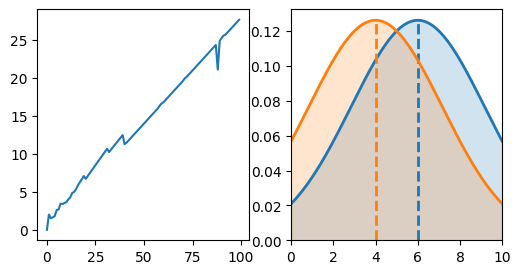

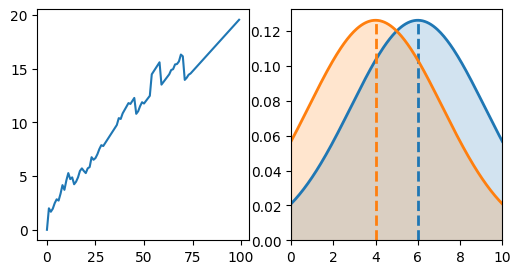

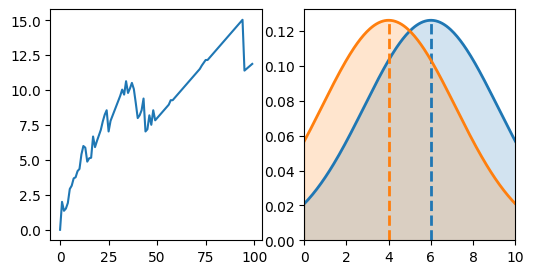

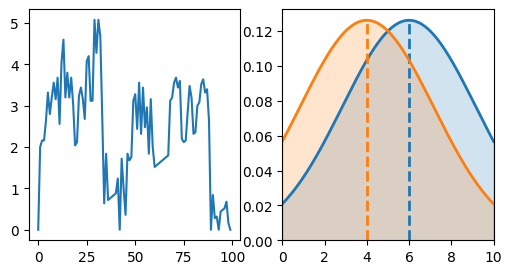

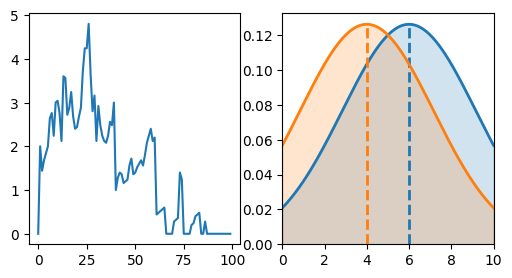

In [61]:
for c_level in [1, 2, 3, 4, 5]:
  regret = [run_sim1(UCB(2, c_level=c_level), mab) for _ in range(50)]
  plot(np.mean(regret, axis=0), mab)

## 4
simulation below assumes a non-stationary multi-armed bandit. specifically in this simulation mean value of distribution of first arm changes in step 100. describe the result of thompson sampling.

In [62]:
def run_sim2(ts, mab, step_num=200, change_step=100):
    init_mean = mab[0].mean
    best_mean = np.max([b.mean for b in mab])
    regret = []
    for i in range(step_num):
        if i == change_step:
            mab[0].mean = 2
            best_mean = np.max([b.mean for b in mab])
            
        # ==================================== Your Code (Begin) ==================================
        # run tompson sampling algorithm and return cumulative regret
        arm_idx = ts.select_arm(i+1)
        reward = mab[arm_idx].sample()
        ts.update(arm_idx, reward)
        regret.append(ts.num_selects[arm_idx] * (best_mean - mab[arm_idx].mean))
        # ==================================== Your Code (End) ====================================
    mab[0].mean = init_mean
    return regret

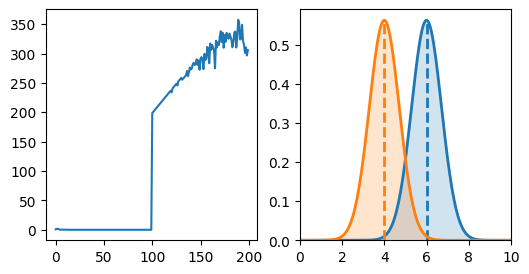

In [63]:
mab = [Arm(6, 0.5), Arm(4, 0.5)]
regret = [run_sim2(ThompsonSampling([b.var for b in mab]), mab) for _ in range(50)]
plot(np.mean(regret, axis=0), mab)

The result of the Thompson Sampling algorithm in this non-stationary bandit scenario will be influenced by the change in the mean value of the first arm's distribution. Initially, the algorithm may explore and select the arms based on their estimated means. However, after the mean change at step 100, the algorithm should adapt and start selecting the arm with the higher mean. As a result, the cumulative regret is expected to decrease over time and converge to a lower value. But as in showed in plots the cumulative regret may not decrease over time and converge to a lower value with the basic Thompson Sampling algorithm. This is because the basic Thompson Sampling algorithm does not explicitly handle non-stationary environments. To improve the results in a non-stationary MAB scenario, one possible approach is to incorporate a sliding window or a decay factor to give more weight to recent observations. This allows the algorithm to adapt more quickly to changes in the environment.

### 4.1
change thompson sampling algorithm to improve results in non-stationary MAB.

In [64]:
class NewThompsonSampling:
    def __init__(self, var_list, buffer_size=30, **kwargs):
        self.n_arms = len(var_list)
        self.var_list = var_list
        self.prior_means = np.zeros((self.n_arms,))
        self.prior_vars = np.ones((self.n_arms,)) * 1000
        self.num_selects = np.zeros((self.n_arms,))
        self.buffer_size = buffer_size
        self.reward_buffer = [[] for _ in range(self.n_arms)]

    def select_arm(self, *args):
        # ==================================== Your Code (Begin) ==================================
        # select arm based on estimate of prior distribution
        # return index of selected arm
        sampled_means = [
            np.random.normal(*x) for x in zip(self.prior_means, self.prior_vars)
        ]
        return np.argmax(sampled_means)
        # ==================================== Your Code (End) ====================================

    def update(self, idx, reward):
        # ==================================== Your Code (Begin) ==================================
        # update prior based on reward
        self.num_selects[idx] += 1
        self.reward_buffer[idx].append(reward)

        if len(self.reward_buffer[idx]) > self.buffer_size:
            old_reward = self.reward_buffer[idx].pop(0)
            old_mean = self.prior_means[idx]
            self.prior_means[idx] -= old_reward / self.buffer_size
            self.prior_vars[idx] += (old_reward - old_mean) * (old_reward - self.prior_means[idx]) / self.buffer_size

        self.prior_means[idx] = (self.prior_vars[idx] / (self.prior_vars[idx] + self.var_list[idx])) * reward \
                                 + (self.var_list[idx] / (self.prior_vars[idx] + self.var_list[idx])) * self.prior_means[idx]
        self.prior_vars[idx] = 1 / (1 / self.prior_vars[idx] + 1 / self.var_list[idx])
        # ==================================== Your Code (End) ====================================


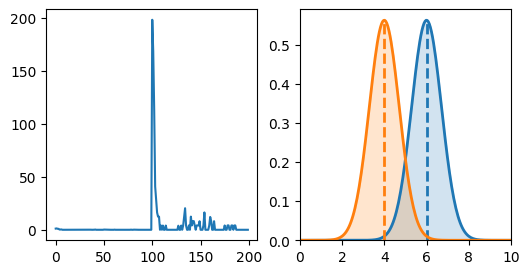

In [66]:
mab = [Arm(6, 0.5), Arm(4, 0.5)]
regret = [run_sim2(NewThompsonSampling([b.var for b in mab]), mab) for _ in range(50)]
plot(np.mean(regret, axis=0), mab)

With this modification, the Thompson Sampling algorithm will adapt more quickly to changes in the mean values of arm distributions in the non-stationary scenario. The cumulative regret is expected to decrease over time and show better performance in adapting to the changing environment.